# MIMIC-III and Support2Cls Data

## MIMIC-III

In [267]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("white")
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, make_gaussian_data

%matplotlib inline

In [139]:
def load_mimiciii_data():
    df_adult = pd.read_csv('adult_icu.gz', compression='gzip')
    
    train_cols = [
    'age', 'first_hosp_stay', 'first_icu_stay', 'eth_asian',
    'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
    'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN',
    'admType_URGENT', 'heartrate_min', 'heartrate_max', 'heartrate_mean',
    'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
    'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
    'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
    'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean',
    'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin',
    'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
    'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate',
    'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc']
    
    label = 'mort_icu'
    X_df = df_adult[train_cols]
    y_df = df_adult[label]
    
    dataset = {
    'problem': 'classification',
    'X': X_df,
    'y': y_df,
    'd_name': 'mimiciii',
    }
    
    return dataset

In [234]:
def train_update_loop(model_fn, x, y, n_train, n_update, n_test, names, num_updates, desired_fpr, seeds):
    seeds = np.arange(seeds)

    rates = {name: [] for name in names}

    for seed in seeds:
        print(seed)
        np.random.seed(seed)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test, stratify=y)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test, stratify=y_test)
        
        data_mean = np.mean(x_train[:, float_cols], 0)
        data_std = np.std(x_train[:, float_cols], 0)

        x_train[:, float_cols] = (x_train[:, float_cols] - data_mean) / data_std
        x_update[:, float_cols] = (x_update[:, float_cols] - data_mean) / data_std
        x_test[:, float_cols] = (x_test[:, float_cols] - data_mean) / data_std

        model = model_fn()
        model.fit(x_train, y_train)
        y_prob = model.predict_proba(x_train)
        
        threshold = find_threshold(y_train, y_prob, desired_fpr)
        
        y_prob = model.predict_proba(x_test)
        y_pred = y_prob[:, 1] > threshold
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
        
        new_model, temp_rates = update_model_feedback(model, x_update, y_update, x_test, y_test, num_updates, intermediate=True, threshold=threshold)

        rates["fpr"].append([initial_fpr] + temp_rates["fpr"])
        rates["tpr"].append([initial_tpr] + temp_rates["tpr"])
        rates["fnr"].append([initial_fnr] + temp_rates["fnr"])
        rates["tnr"].append([initial_tnr] + temp_rates["tnr"])
            
    return rates

In [243]:
def gold_standard_loop(model_fn, x, y, n_train, n_update, n_test, names, desired_fpr, seeds):
    seeds = np.arange(seeds)
    rates = {name: [] for name in names}
    
    for seed in seeds:
        np.random.seed(seed)
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test, stratify=y)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test, stratify=y_test)
        
        data_mean = np.mean(x_train[:, float_cols], 0)
        data_std = np.std(x_train[:, float_cols], 0)

        x_train[:, float_cols] = (x_train[:, float_cols] - data_mean) / data_std
        x_update[:, float_cols] = (x_update[:, float_cols] - data_mean) / data_std
        x_test[:, float_cols] = (x_test[:, float_cols] - data_mean) / data_std
        
        model = model_fn()
        model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))
        y_prob = model.predict_proba(x_train)
        
        threshold = find_threshold(y_train, y_prob, desired_fpr)
                  
        y_prob = model.predict_proba(x_test)
        y_pred = y_prob[:, 1] > threshold
        gold_standard_tnr, gold_standard_fpr, gold_standard_fnr, gold_standard_tpr = eval_model(y_test, y_pred)
                  
        rates["fpr"].append(gold_standard_fpr)
        rates["tpr"].append(gold_standard_tpr)
        rates["fnr"].append(gold_standard_fnr)
        rates["tnr"].append(gold_standard_tnr)
        
    return rates

In [226]:
def find_threshold(y, y_prob, desired_fpr):
    thresholds = np.linspace(0.05, 0.95, 100)
    best_threshold = None
    best_fpr_diff = 0.0
    best_fpr = 0.0
    
    for threshold in thresholds:
        temp_pred = y_prob[:, 1] >= threshold
        temp_tnr, temp_fpr, temp_fnr, temp_tpr = eval_model(y, temp_pred)
        
#         print("Threshold: {} | FPR: {}".format(threshold, temp_fpr))
#         print("Best FPR diff: {} | (desired_fpr - temp_fpr) = {} | Current FPR: {}".format(best_fpr_diff, (desired_fpr - temp_fpr), temp_fpr))
        
        if temp_fpr < desired_fpr and best_threshold is None:
            best_threshold = threshold
            best_fpr_diff = desired_fpr - temp_fpr
            best_fpr = temp_fpr
        elif temp_fpr < desired_fpr and (desired_fpr - temp_fpr) < best_fpr_diff:
            best_threshold = threshold
            best_fpr_diff = desired_fpr - temp_fpr
            best_fpr = temp_fpr
    
    return best_threshold

In [184]:
def results_to_dataframe(rates):
    data = {"rate": [], "type": [], "num_updates": []}

    for name in rates.keys():
        for i in range(len(rates[name])):
            data["rate"] += rates[name][i]
            data["type"] += [name] * (len(rates[name][i]))
            data["num_updates"] +=  list(np.arange(len(rates[name][i])))

    return pd.DataFrame(data)

In [146]:
def lr_wrapper(class_weight):
    def lr():
        return linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log", class_weight=class_weight)
    
    return lr

In [147]:
def svm_wrapper(class_weight):
    def svm():
        return linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="hinge", class_weight=class_weight)
    
    return svm

In [251]:
def plot_rate(data, rate_type, model_name, gs_line):
    fig = plt.figure(figsize=(13, 9))
    ax = fig.add_subplot(111)
    sns.lineplot(x="num_updates", y="rate", data=data.loc[data["type"] == rate_type], err_style="band", ax=ax, ci="sd")
    # sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "fpr"], ax=ax)
    # sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
    ax.set_xlabel("Num Updates", size=26, labelpad=10.0)
    ax.set_ylabel(rate_type.upper(), size=26, labelpad=10.0)
    ax.axhline(gs_line, ls="--")
    ax.set_xlim([0,500])

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    fig.savefig("figures/real_data/mimic_{}_{}.png".format(model_name, rate_type), dpi=300)
    fig.savefig("figures/real_data/mimic_{}_{}.pdf".format(model_name, rate_type), dpi=300)

In [289]:
def plot_rates(data, rate_types, model_name, gs_lines):
    fig = plt.figure(figsize=(13, 9))
    ax = fig.add_subplot(111)
    g = sns.lineplot(x="num_updates", y="rate", hue="type", data=data.loc[data["type"].isin(rate_types)], err_style="band", ax=ax, ci="sd", palette="bright")
    # sns.boxplot(x="num_updates", y="rate", hue="time", data=data.loc[data["type"] == "fpr"], ax=ax)
    # sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
    ax.set_xlabel("Num Updates", size=30, labelpad=10.0)
    ax.set_ylabel("Rate", size=30, labelpad=10.0)
    
    for i in range(len(gs_lines)):
        ax.axhline(gs_lines[i], ls="--", color=g.lines[i].get_color())

    ax.set_xlim([0,500])

    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=24)
    
    legend = ax.legend(title="Rate Type", title_fontsize=30, labels=list(map(lambda x: x.upper(), rate_types)), loc="upper left")
    legend.texts[0].set_size(24)
    fig.savefig("figures/real_data/mimic_{}_{}.png".format(model_name, rate_types), dpi=300)
    fig.savefig("figures/real_data/mimic_{}_{}.pdf".format(model_name, rate_types), dpi=300)

In [227]:
num_updates = 500
names = ["fpr", "tpr", "fnr", "tnr", "auc"]
seeds = 100

In [228]:
data = load_mimiciii_data()
float_cols = []

for i, column in enumerate(data["X"].columns):
    if "float" in str(data["X"][column].dtype):
        float_cols.append(i)
        
float_cols = np.array(float_cols)

x = data["X"].to_numpy()
y = data["y"].to_numpy()

In [229]:
prop_0 = np.sum(y == 0) / float(len(y))
prop_1 = np.sum(y == 1) / float(len(y))

weight_0 = float(len(y)) / (2 * np.sum(y == 0))
weight_1 = float(len(y)) / (2 * np.sum(y == 1))

print("Positive Samples: {}".format(prop_1))
print("Negative Samples: {}".format(prop_0))

Positive Samples: 0.09839842035980693
Negative Samples: 0.901601579640193


### Logistic Regression

In [230]:
n_train = int(len(x) * 0.4)
n_update = int(len(x) * 0.4)
n_test = int(len(x) * 0.2)

In [231]:
model_fn = lr_wrapper(None)

In [232]:
desired_fpr = 0.1

In [235]:
rates = train_update_loop(model_fn, x, y, n_train, n_update, n_test, names, num_updates, desired_fpr, seeds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [244]:
gold_standard = gold_standard_loop(model_fn, x, y, n_train, n_update, n_test, names, desired_fpr, seeds)

In [246]:
gs_mean = np.mean(gold_standard["fpr"])

In [236]:
dataframe = results_to_dataframe(rates)

In [276]:
temp = map(lambda x: x.upper(), ["fpr"])

In [278]:
list(temp)

['FPR']

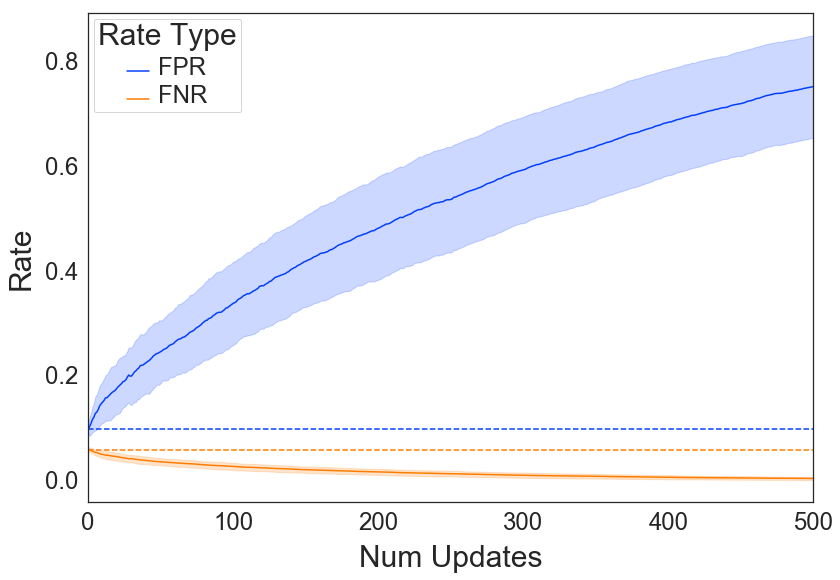

In [290]:
plot_rates(dataframe, ["fpr", "fnr"], "lr", [np.mean(gold_standard["fpr"]), np.mean(gold_standard["fnr"])])

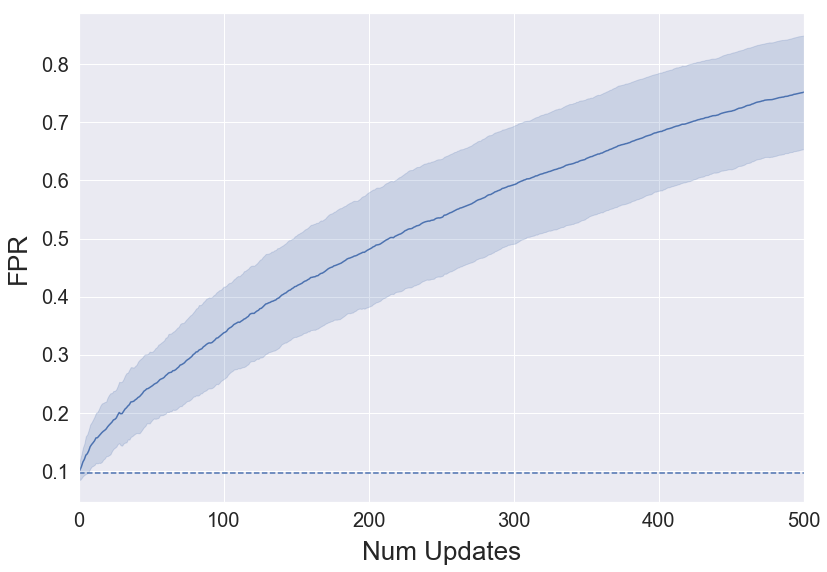

In [252]:
plot_rate(dataframe, "fpr", "lr", gs_mean)

In [216]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, stratify=y)
x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

data_mean = np.mean(x_train[:, float_cols], 0)
data_std = np.std(x_train[:, float_cols], 0)

x_train[:, float_cols] = (x_train[:, float_cols] - data_mean) / data_std
x_update[:, float_cols] = (x_update[:, float_cols] - data_mean) / data_std
x_test[:, float_cols] = (x_test[:, float_cols] - data_mean) / data_std

model = model_fn()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
y_score = model.decision_function(x_test)
y_prob = model.predict_proba(x_train)
initial_auc = roc_auc_score(y_train, y_prob[:, 1])

Try different thresholds

In [218]:
thresholds = np.linspace(0.05, 0.95, 100)

In [219]:
train_neg = np.sum(y_train == 0)
train_pos = np.sum(y_train == 1)


train_neg_prop = float(train_neg) / float(len(y_train))
train_pos_prop = float(train_pos) / float(len(y_train))

In [220]:
for threshold in thresholds:
    temp_pred = y_prob[:, 1] >= threshold
    temp_tnr, temp_fpr, temp_fnr, temp_tpr = eval_model(y_train, temp_pred)
    
    print("Threshold: {:.3f} | FPR: {:.3f} | TPR: {:.3f} / {:.3f} | FNR: {:.3f} | TNR: {:.3f} / {:.3f}".format(threshold, temp_fpr, temp_tpr, train_pos_prop, temp_fnr, temp_tnr, train_neg_prop))
#     print("Threshold: {:.3f} | Adjusted FPR: {:.3f} | TPR: {:.3f} | FNR: {:.3f} | TNR: {:.3f}".format(threshold, temp_fpr, temp_tpr, temp_fnr, temp_tnr))

Threshold: 0.050 | FPR: 0.388 | TPR: 0.077 / 0.098 | FNR: 0.022 | TNR: 0.513 / 0.902
Threshold: 0.059 | FPR: 0.340 | TPR: 0.073 / 0.098 | FNR: 0.026 | TNR: 0.561 / 0.902
Threshold: 0.068 | FPR: 0.305 | TPR: 0.069 / 0.098 | FNR: 0.029 | TNR: 0.597 / 0.902
Threshold: 0.077 | FPR: 0.274 | TPR: 0.067 / 0.098 | FNR: 0.032 | TNR: 0.627 / 0.902
Threshold: 0.086 | FPR: 0.245 | TPR: 0.064 / 0.098 | FNR: 0.034 | TNR: 0.657 / 0.902
Threshold: 0.095 | FPR: 0.220 | TPR: 0.061 / 0.098 | FNR: 0.037 | TNR: 0.682 / 0.902
Threshold: 0.105 | FPR: 0.199 | TPR: 0.059 / 0.098 | FNR: 0.040 | TNR: 0.703 / 0.902
Threshold: 0.114 | FPR: 0.182 | TPR: 0.057 / 0.098 | FNR: 0.042 | TNR: 0.720 / 0.902
Threshold: 0.123 | FPR: 0.166 | TPR: 0.055 / 0.098 | FNR: 0.043 | TNR: 0.736 / 0.902
Threshold: 0.132 | FPR: 0.153 | TPR: 0.053 / 0.098 | FNR: 0.045 | TNR: 0.748 / 0.902
Threshold: 0.141 | FPR: 0.141 | TPR: 0.051 / 0.098 | FNR: 0.047 | TNR: 0.760 / 0.902
Threshold: 0.150 | FPR: 0.132 | TPR: 0.049 / 0.098 | FNR: 0.049 |

## Support 2

In [ ]:
def load_support2cls_data():
    df = pd.read_csv('support2.csv')
    one_hot_encode_cols = ['sex', 'dzclass', 'race' , 'ca', 'income']
    target_variables = ['hospdead']
    remove_features = ['death', 'slos', 'd.time', 'dzgroup', 'charges', 'totcs
    t',
    'totmcst', 'aps', 'sps', 'surv2m', 'surv6m', 'prg2m',
    'prg6m',
    'dnr', 'dnrday', 'avtisst', 'sfdm2']
    df = df.drop(remove_features, axis=1)
    rest_colmns = [c for c in df.columns if c not in (one_hot_encode_cols + ta
    rget_variables)]
    # Impute the missing values for 0.
    df[rest_colmns] = df[rest_colmns].fillna(0.)
    df = pd.get_dummies(df, prefix=one_hot_encode_cols)
    X_df = df.drop(target_variables, axis=1)
    X_df = X_df.astype('float64')
    
    y_df = df[target_variables[0]]
    dataset = {
    'problem': 'classification',
    'X': X_df,
    'y': y_df,
    'd_name': 'support2cls',
    }
    
    return dataset